In [9]:
%matplotlib inline

In [10]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import LogLocator
import matplotlib as mpl
from matplotlib import rc
import paleopy as paleopy
import swordfish as sf
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz, quad
from scipy.special import erf
from scipy.ndimage.filters import gaussian_filter1d
import configparser
from tqdm import tqdm
from WIMpy import DMUtils as DMU
import os 

C:\Users\emili\AppData\Local\Temp\ipykernel_11040\925412520.py:11: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [11]:
class Mineral:
    def __init__(self, mineral):
        
        #mineral in config
        
        self.name = mineral
        
        
        config = configparser.ConfigParser()
        config.read("Data/MineralList.txt")
        data = config[mineral]
    
        nuclist = data["nuclei"].split(",")
        self.nuclei = [x.strip(' ') for x in nuclist]
        
        self.N_nuclei = len(self.nuclei)
        
        self.stoich = np.asarray(data["stoich"].split(","), dtype=float)
        
        #self.abun = np.asarray(data["abundances"].split(","), dtype=float)
        self.N_p = np.asarray(data["N_p"].split(","), dtype=float)
        self.N_n = np.asarray(data["N_n"].split(","), dtype=float)
        
        #Check that there's the right number of everything
        if (len(self.stoich) != self.N_nuclei):
            raise ValueError("Number of stoich. ratio entries doesn't match number of nuclei for mineral <" + self.name + ">...")
        if (len(self.N_p) != self.N_nuclei):
            raise ValueError("Number of N_p entries doesn't match number of nuclei for mineral <" + self.name + ">...")
        if (len(self.N_p) != self.N_nuclei):
            raise ValueError("Number of N_n entries doesn't match number of nuclei for mineral <" + self.name + ">...")
        
        self.shortname = data["shortname"]
        self.U_frac = float(data["U_frac"]) #Uranium fraction by weight
        
        #Calculate some derived stuff
        self.molarmass = np.sum(self.stoich*(self.N_p + self.N_n))
        self.abun = self.stoich*(self.N_p + self.N_n)/self.molarmass

        
        self.dEdx_interp = []
        self.Etox_interp = []
        self.xtoE_interp = []
        
        self.Etox_interp_Th = None
        
        if (self.shortname == "Zab"):
            self.loadSRIMdata(modifier="CC2338")
        elif (self.shortname == "Syl"):
            self.loadSRIMdata(modifier="CC1")
        else:
            self.loadSRIMdata()
        
        self.NeutronBkg_interp = []
        
        self.loadNeutronBkg()
        
        #self.loadFissionBkg()
        
        #Do we need these cumbersome dictionaries...?
        self.dEdx_nuclei = dict(zip(self.nuclei, self.dEdx_interp))
        self.Etox_nuclei = dict(zip(self.nuclei, self.Etox_interp))
        self.xtoE_nuclei = dict(zip(self.nuclei, self.xtoE_interp))
        self.ratio_nuclei = dict(zip(self.nuclei, self.abun))

    #--------------------------------   
    def showProperties(self):
        print("Mineral name:", self.name)
        print("    N_nuclei:", self.N_nuclei)
        print("    Molar mass:", self.molarmass, " g/mol")
        print("    nucleus \t*\t abun.  *\t (N_p, N_n)")
        print(" **************************************************")
        for i in range(self.N_nuclei):
            print("    " + self.nuclei[i] + "\t\t*\t" + str(self.abun[i]) + "\t*\t(" +str(self.N_p[i]) 
                  + ", " + str(self.N_n[i]) + ")")
         
    #--------------------------------   
    def loadSRIMdata(self, modifier=None):
        #The modifier can be used to identify a particular version of the SRIM
        #track length files (e.g. modifier="CC2338")
        
        SRIMfolder = "Data/dRdESRIM/"

        self.Etox_interp = []
        self.xtoE_interp = []
        self.dEdx_interp = []
    
        for nuc in self.nuclei:
            #Construct the SRIM output filename
            infile = SRIMfolder + nuc + "-" + self.shortname
            if not(modifier == None):
                infile += "-" + modifier
            infile += ".txt"
        
            E, dEedx, dEndx = np.loadtxt(infile, usecols=(0,1,2), unpack=True)
            dEdx = dEedx + dEndx    #Add electronic stopping to nuclear stopping
            dEdx *= 1.e-3           # Convert keV/micro_m to keV/nm
            x = cumtrapz(1./dEdx,x=E, initial=0)    #Calculate integrated track lengths
        
            #Generate interpolation function (x(E), E(x), dEdx(x))
            self.Etox_interp.append(interp1d(E, x, bounds_error=False, fill_value='extrapolate'))
            self.xtoE_interp.append(interp1d(x, E, bounds_error=False, fill_value='extrapolate'))
            self.dEdx_interp.append(interp1d(x, dEdx, bounds_error=False, fill_value='extrapolate'))    
    
        #Load in the Thorium track lengths...
        #Construct the SRIM output filename
        infile = SRIMfolder + "Th-" + self.shortname
        if not(modifier == None):
            infile += "-" + modifier
        infile += ".txt"
        
        E, dEedx, dEndx = np.loadtxt(infile, usecols=(0,1,2), unpack=True)
        dEdx = dEedx + dEndx    #Add electronic stopping to nuclear stopping
        dEdx *= 1.e-3           # Convert keV/micro_m to keV/nm
        x = cumtrapz(1./dEdx,x=E, initial=0)    #Calculate integrated track lengths
        self.Etox_interp_Th = interp1d(E, x, bounds_error=False, fill_value='extrapolate')
    
    

    
    #--------------------------------
    def showSRIM(self):
        print("Plotting SRIM data for " + self.name + ":")
        x_list = np.logspace(0,4,100)

        fig, axarr = plt.subplots(figsize=(10,4),nrows=1, ncols=2)
        ax1, ax2 = axarr
        for i in range(self.N_nuclei):
            ax1.loglog(x_list, self.dEdx_interp[i](x_list),label=self.nuclei[i])
        ax1.set_ylabel("dE/dx [keV/nm]")
        ax1.set_xlabel("x [nm]")
        ax1.legend()
                
        E_list = np.logspace(-3, 3, 500) # keV    
        
        for i in range(self.N_nuclei):
            ax2.loglog(E_list, self.Etox_interp[i](E_list),label=self.nuclei[i])
        ax2.set_ylabel("x [nm]")
        ax2.set_xlabel("E [keV]")
        ax2.legend()
        
        plt.savefig(self.name + 'SRIM.pdf', bbox_inches='tight')
        plt.show()
        
        
    #--------------------------------
    def dRdx(self, x_bins, sigma, m, gaussian=False):
        x_width = np.diff(x_bins)
        x = x_bins[:-1] + x_width/2
        #Returns in events/kg/Myr/nm

        
        dRdx = np.zeros_like(x)
        for i, nuc in enumerate(self.nuclei):
            # Ignore recoiling hydrogen nuclei
            if (nuc != "H"):
                Etemp = self.xtoE_nuclei[nuc](x)
                dRdx_nuc = (DMU.dRdE_standard(Etemp, self.N_p[i], self.N_n[i], m, sigma, \
                                        vlag=248.0, sigmav=166.0, vesc=550.0)*self.dEdx_nuclei[nuc](x))
                dRdx += self.ratio_nuclei[nuc]*dRdx_nuc
            
        if gaussian:
            dRdx = gaussian_filter1d(dRdx,1)+1e-20
        return dRdx*1e6*365

    def dRdx_generic_vel(self, x_bins, sigma, m, eta, gaussian=False):
        x_width = np.diff(x_bins)
        x = x_bins[:-1] + x_width/2
        #Returns in events/kg/Myr/nm

        
        dRdx = np.zeros_like(x)
        for i, nuc in enumerate(self.nuclei):
            # Ignore recoiling hydrogen nuclei
            if (nuc != "H"):
                Etemp = self.xtoE_nuclei[nuc](x)
                dRdx_nuc = (DMU.dRdE_generic(Etemp, self.N_p[i], self.N_n[i], m, sigma, eta)*self.dEdx_nuclei[nuc](x))
                dRdx += self.ratio_nuclei[nuc]*dRdx_nuc
            
        if gaussian:
            dRdx = gaussian_filter1d(dRdx,1)+1e-20
        return dRdx*1e6*365
    
    #--------------------------------
    def dRdx_nu(self,x_bins, components=False, gaussian=False):
        x_width = np.diff(x_bins)
        x = x_bins[:-1] + x_width/2
        #Returns in events/kg/Myr/nm
        nu_list = ['DSNB', 'atm', 'hep', '8B', '15O', '17F', '13N', 'pep','pp','7Be-384','7Be-861']
    
        E_list = np.logspace(-3, 3, 5000) # keV
    
        if components:
            dRdx = []
            for j, nu_source in enumerate(nu_list):
                dRdx_temp = np.zeros_like(x)
                for i, nuc in enumerate(self.nuclei):
                    if (nuc != "H"):
                        xtemp = self.Etox_nuclei[nuc](E_list)
                        dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(E_list, self.N_p[i], self.N_n[i], flux_name=nu_source)
                                                            *self.dEdx_nuclei[nuc](xtemp))
                        temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
                        dRdx_temp += self.ratio_nuclei[nuc]*temp_interp(x)
                    
                if gaussian:
                    dRdx.append(gaussian_filter1d(dRdx_temp*1e6*365,1)+1e-20)
                else:
                    dRdx.append(dRdx_temp*1e6*365+1e-20)
        else:
            dRdx = np.zeros_like(x)
            for i, nuc in enumerate(self.nuclei):
                if (nuc != "H"):
                    xtemp = self.Etox_nuclei[nuc](E_list)
                    dRdx_nuc = (np.vectorize(DMU.dRdE_CEvNS)(E_list, self.N_p[i], self.N_n[i], flux_name='all')
                                                        *self.dEdx_nuclei[nuc](xtemp))
                    temp_interp = interp1d(xtemp, dRdx_nuc, fill_value='extrapolate')
                    dRdx += self.ratio_nuclei[nuc]*temp_interp(x)*1e6*365
            if gaussian:
                dRdx = gaussian_filter1d(dRdx*1e6*365,1)+1e-20
                
        return dRdx
    
    def xT_Thorium(self):
        E_Thorium = 72. #keV
        return self.Etox_interp_Th(E_Thorium)
    
    def norm_Thorium(self, T):
        #T is in years. Returns events/kg/Myr
        T_half_238 = 4.468e9
        T_half_234 = 2.455e5
        
        lam_238 = np.log(2)/T_half_238
        lam_234 = np.log(2)/T_half_234
        
        #Avocado's constant
        N_A = 6.022140857e23
        

        n238_permass = self.U_frac*N_A*1e3/238.0 #Number of U238 atoms *per kg*
        Nalpha = n238_permass*(lam_238/(lam_234 - lam_238))*(np.exp(-lam_238*T) - np.exp(-lam_234*T))
        return Nalpha/(T*1e-6)
        
    def loadNeutronBkg(self):
        
        fname = "Data/" + self.name + "_ninduced_wan.dat"

        #Read in the column headings so you know which element is which
        f = open(fname)
        head = f.readlines()[1]
        columns = head.split(",")
        columns = [c.strip() for c in columns]
        ncols = len(columns)
        f.close()
        
        data = np.loadtxt(fname)
        E_list = data[:,0]
        
        self.NeutronBkg_interp = []
        
        for i, nuc in enumerate(self.nuclei):
            dRdE_list = 0.0*E_list
            #How many characters is the length of the element name you're looking for
            nchars = len(nuc)
            for j in range(ncols):
                #Check if this is the correct element
                if (columns[j][0:nchars] == nuc):
                    dRdE_list += data[:,j]
            
            (self.NeutronBkg_interp).append(interp1d(E_list, dRdE_list,bounds_error=False,fill_value=0.0))
            
    def dRdx_neutrons(self, x_bins):
        x_width = np.diff(x_bins)
        x = x_bins[:-1] + x_width/2
        #Returns in events/kg/Myr/nm
        
        
        dRdx = np.zeros_like(x)
        for i, nuc in enumerate(self.nuclei):
            if (nuc != "H"):
                E_list = self.xtoE_nuclei[nuc](x) 
                dRdx_nuc = self.NeutronBkg_interp[i](E_list)*self.dEdx_nuclei[nuc](x)
                dRdx += dRdx_nuc #Isotope fractions are already included in the tabulated neutron spectra
                
        return dRdx*self.U_frac/0.1e-9 #Tables were generated for a Uranium fraction of 0.1 ppb




code to plot the spectra for any input mineral with the appropriate SRIM files

In [12]:
def plotSpectrum(mineral):
    
    x_bins = np.logspace(0,3,100)

    plt.figure(figsize=(7,5))

    plt.title(mineral.name + r" Track Length Spectrum")

    # Signal spectrum for a given DM cross section and mass
    # These functions SHOULD work if we have exact same file formatting as authors
    # need to re-do and paleopy functions
    plt.loglog(x_bins[:-1], mineral.dRdx(x_bins, 1e-45, 5), label=r'$5\,\mathrm{GeV}$')
    plt.loglog(x_bins[:-1], mineral.dRdx(x_bins, 1e-45, 50), label=r'$50\,\mathrm{GeV}$')
    plt.loglog(x_bins[:-1], mineral.dRdx(x_bins, 1e-45, 500), label=r'$500\,\mathrm{GeV}$')

    # Background spectrum for neutrinos
    plt.loglog(x_bins[:-1], mineral.dRdx_nu(x_bins), linestyle='--',label=r'Neutrinos')

    # Neutron-induced backgrounds
    plt.loglog(x_bins[:-1], mineral.dRdx_neutrons(x_bins), linestyle=':', label='Neutrons')
    
    
    
    #Plot the line from Thorium
    x_Th = mineral.xT_Thorium()
    plt.loglog([x_Th, x_Th], [1e-10, mineral.norm_Thorium(T=1e6)], linestyle='-.',label=r'$1\alpha$-Thorium')

    plt.legend(fontsize=12)

    ax = plt.gca()
    plt.text(0.05, 0.9, r"$\sigma_p^{\mathrm{SI}}=10^{-45}\,\mathrm{cm}^2$",fontsize=16.0, transform=ax.transAxes)
    
    plt.ylabel("dR/dx [1/nm/kg/Myr]")
    plt.xlabel("x [nm]")
    plt.ylim(1e-4,1e11)
    plt.xlim(1,1000)

    plt.savefig("plots/" + mineral.name + "_spectra.pdf",bbox_inches="tight")
    print([x_Th, x_Th], [1e-10, mineral.norm_Thorium(T=1e6)])
    plt.show()

#### Track Length Spectrum for Halite

Mineral name: Halite
    N_nuclei: 2
    Molar mass: 58.45  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    Na		*	0.39349871685201027	*	(11.0, 12.0)
    Cl		*	0.6065012831479898	*	(17.0, 18.45)
Plotting SRIM data for Halite:


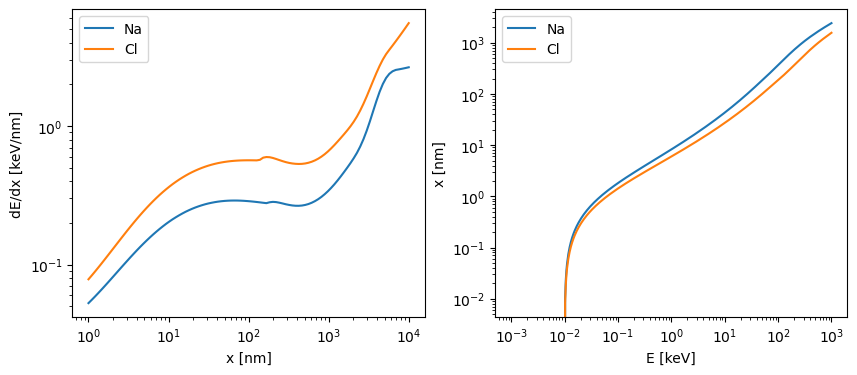

In [13]:
Hal = Mineral("Halite")
Hal.showProperties()
Hal.showSRIM()

#### Track Length Spectrum for Epsomite

In [7]:
#Epso = Mineral("Epso")
#Epso.showProperties()
#Epso.showSRIM()

In [8]:
#plotSpectrum(Epso)

#### Track Length Spectrum for Phlogopite Mica

Mineral name: Phlogopite
    N_nuclei: 7
    Molar mass: 418.9  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    K		*	0.09310097875387921	*	(19.0, 20.0)
    Mg		*	0.17402721413225117	*	(12.0, 12.3)
    Al		*	0.06445452375268561	*	(13.0, 14.0)
    Si		*	0.20052518500835523	*	(14.0, 14.0)
    H		*	0.0023872045834328003	*	(1.0, 0.0)
    O		*	0.42014800668417285	*	(8.0, 8.0)
    F		*	0.04535688708522321	*	(9.0, 10.0)
Plotting SRIM data for Phlogopite:


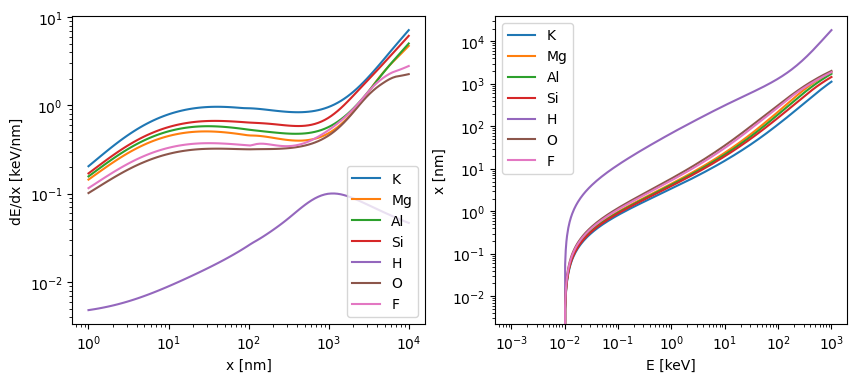

In [9]:
Phlo = Mineral("Phlogopite")
Phlo.showProperties()
Phlo.showSRIM()

 DMutils.py: Loading neutrino flux for the first time...
Loading neutrino fluxes for...
    DSNB
    atm
    hep
    8B
    15O
    17F
    pep
    13N
    pp
    7Be-384
    7Be-861
...done.
[array(45.37452832), array(45.37452832)] [1e-10, 1307579475.0322268]


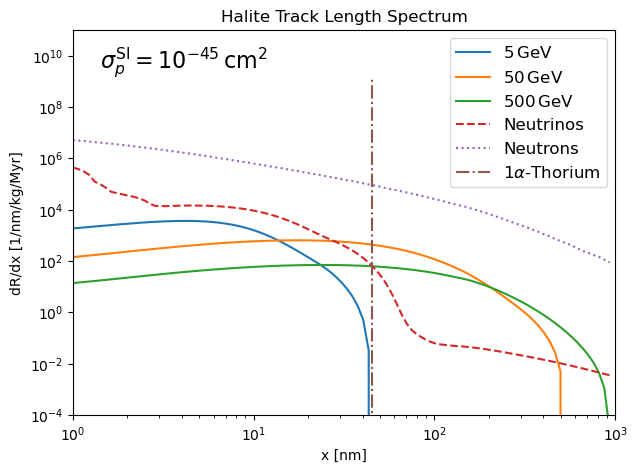

In [6]:
plotSpectrum(Hal)

[array(31.20507616), array(31.20507616)] [1e-10, 13075794750.322266]


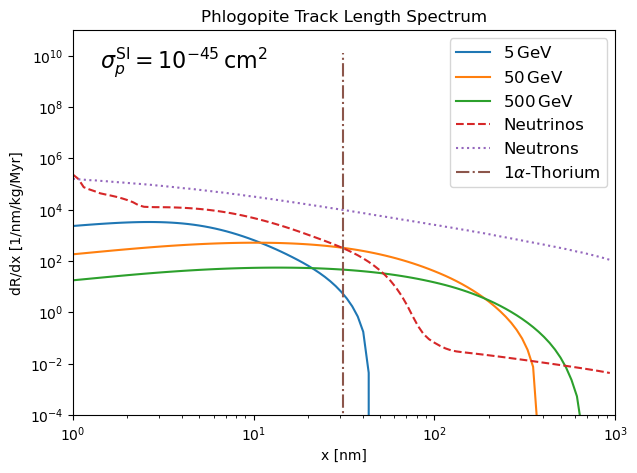

In [10]:
plotSpectrum(Phlo)

Mineral name: Muscovite
    N_nuclei: 5
    Molar mass: 398.0  g/mol
    nucleus 	*	 abun.  *	 (N_p, N_n)
 **************************************************
    K		*	0.09798994974874371	*	(19.0, 20.0)
    Al		*	0.20351758793969849	*	(13.0, 14.0)
    Si		*	0.21105527638190955	*	(14.0, 14.0)
    H		*	0.005025125628140704	*	(1.0, 0.0)
    O		*	0.4824120603015075	*	(8.0, 8.0)
Plotting SRIM data for Muscovite:


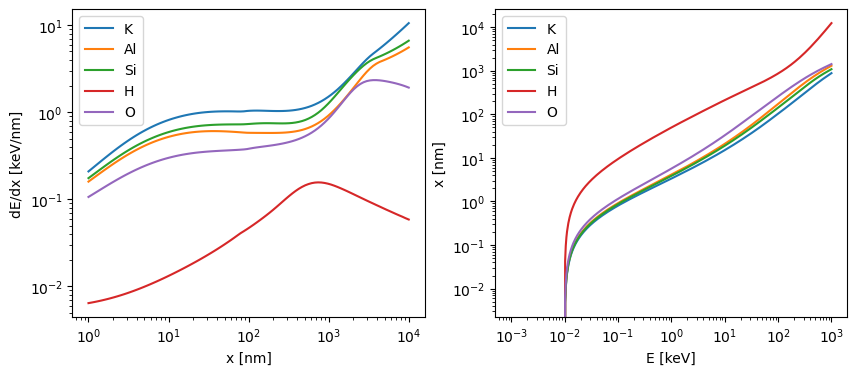

In [14]:
Musc = Mineral("Muscovite")
Musc.showProperties()
Musc.showSRIM()

[array(30.57572853), array(30.57572853)] [1e-10, 13075794750.322266]


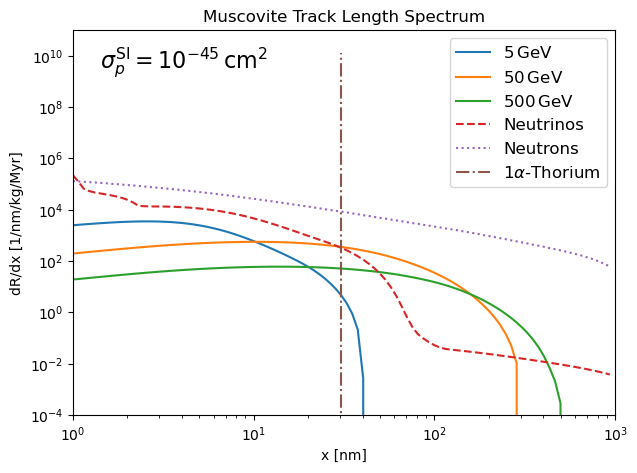

In [12]:
plotSpectrum(Musc)

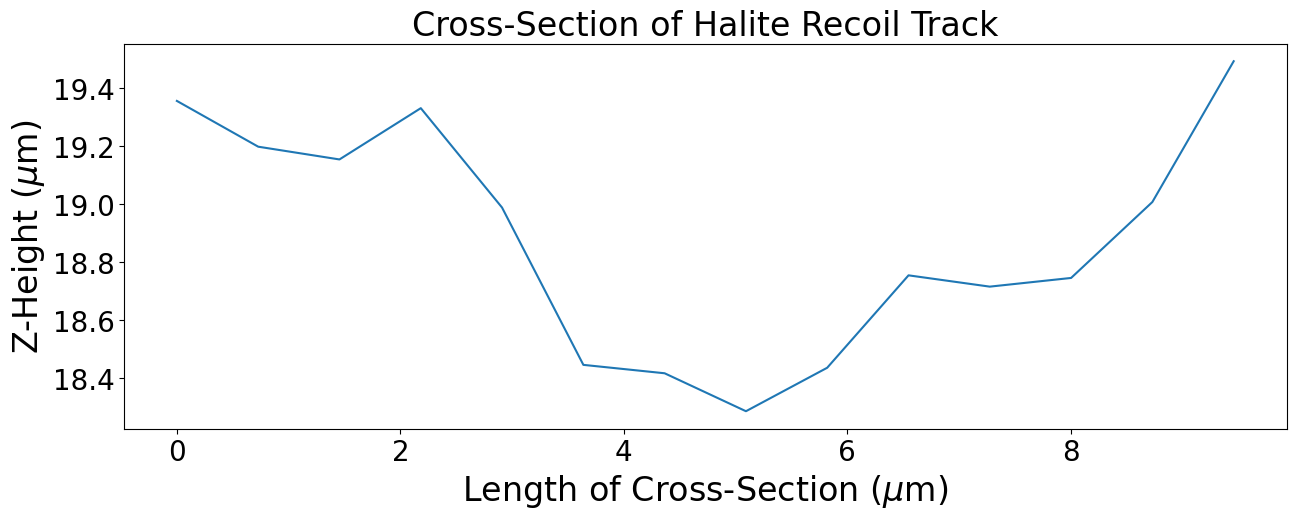

In [13]:
X = [0, 0.728, 1.455, 2.183, 2.91, 3.638, 4.365, 5.093, 5.82, 6.548, 7.275, 8.003, 8.73, 9.458]
Y = [19.356, 19.198, 19.154, 19.331, 18.988, 18.445, 18.416, 18.285, 18.435, 18.754, 18.715, 18.745, 19.007, 19.493]

plt.figure(figsize=(15,5))
plt.ylabel('Z-Height ($\mu$m)', fontsize=24)
plt.xlabel('Length of Cross-Section ($\mu$m)', fontsize=24)
plt.title('Cross-Section of Halite Recoil Track', fontsize=24)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(X,Y)

In [14]:
#T = range(100000, 10000000000)

#T is in years. Returns events/kg/Myr
T_half_238 = 4.468e9
T_half_234 = 2.455e5
        
lam_238 = np.log(2)/T_half_238
lam_234 = np.log(2)/T_half_234
        
#Avocado's constant
N_A = 6.022140857e23
        
n238_permass = 0.1e9*N_A*1e3/238.0 #Number of U238 atoms *per kg*
x_coordinates = range(10000000,100000000,100000)
matrix = []
for T in range(10000000,100000000,100000):
    Nalpha = n238_permass*(lam_238/(lam_234 - lam_238))*(np.exp(-lam_238*T) - np.exp(-lam_234*T))

    X = Nalpha/(T)
    matrix.append(X)
    

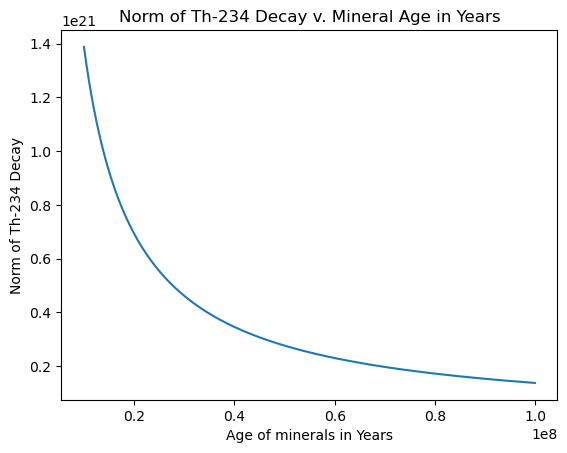

In [15]:
plt.xlabel("Age of minerals in Years")
plt.ylabel("Norm of Th-234 Decay")
plt.title("Norm of Th-234 Decay v. Mineral Age in Years")

plt.plot(x_coordinates, matrix)

In [15]:
from scipy.interpolate import InterpolatedUnivariateSpline
import scipy.integrate as integrate

0.0004275019782221607

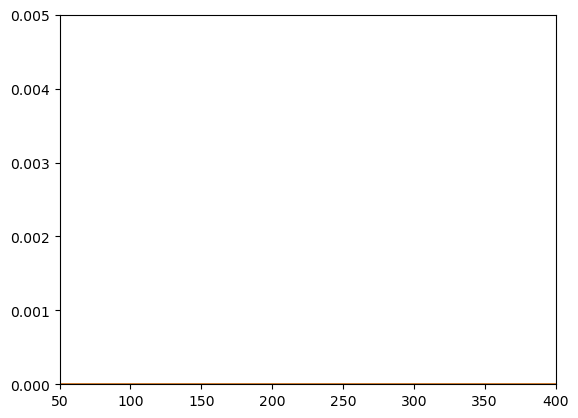

In [18]:
##integration over dR/dx for WIMP DM 5GeV

x_bins = np.logspace(0,3,100)

X = x_bins[:-1]

# Signal spectrum for a given DM cross section and mass
Y_5 = Musc.dRdx(x_bins, 1e-45, 5)

f = InterpolatedUnivariateSpline(X, Y_5)  # cubic spline default

plt.plot(X,f(X))
plt.plot(X,Y_5)
plt.xlim(50,400)
plt.ylim(0,0.005)

f.integral(50, 400)

5561.408264612731

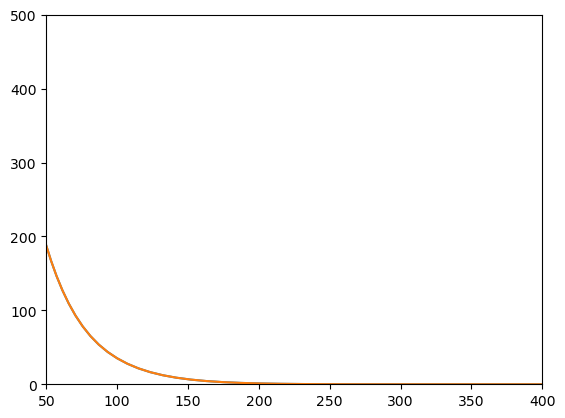

In [19]:
# integration for WIMP DM 50GeV

Y_50 = Musc.dRdx(x_bins, 1e-45, 50)

f = InterpolatedUnivariateSpline(X, Y_50)  # cubic spline default

plt.plot(X,f(X))
plt.plot(X,Y_50)
plt.xlim(50,400)
plt.ylim(0,500)

f.integral(50, 400)

2030.8851796010686

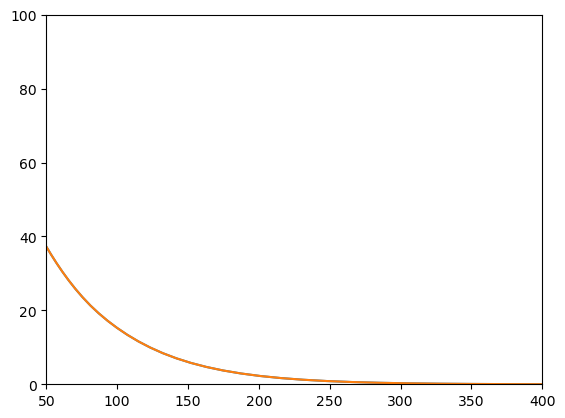

In [21]:
# integration for WIMP DM 500GeV

Y_500 = Musc.dRdx(x_bins, 1e-45, 500)

f = InterpolatedUnivariateSpline(X, Y_500)  # cubic spline default

plt.plot(X,f(X))
plt.plot(X,Y_500)
plt.xlim(50,400)
plt.ylim(0,100)

f.integral(50, 400)

198.50096878907195

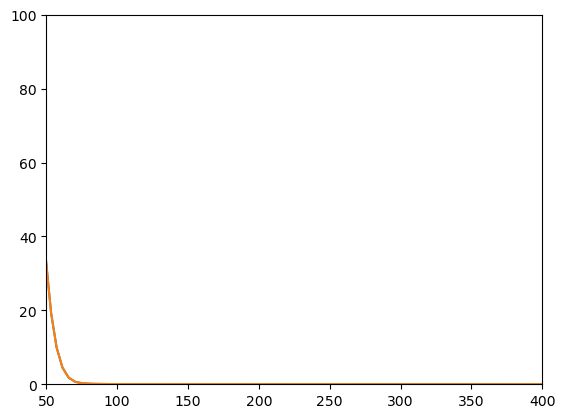

In [22]:
# Background spectrum for neutrinos
Y_neutrino = Musc.dRdx_nu(x_bins)

f = InterpolatedUnivariateSpline(X, Y_neutrino)  # cubic spline default

plt.plot(X,f(X))
plt.plot(X,Y_neutrino)
plt.xlim(50,400)
plt.ylim(0,100)

f.integral(50, 400)

422277.9546300912

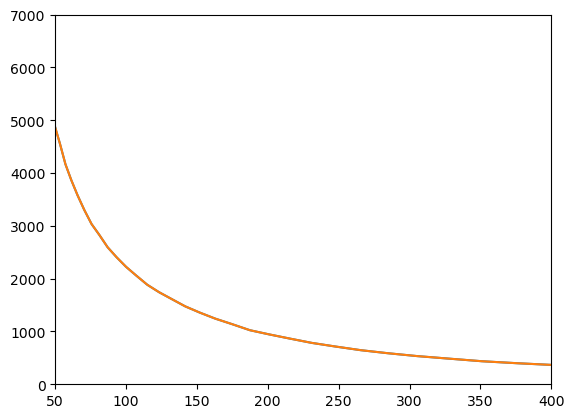

In [51]:
# Neutron-induced backgrounds
Y_neutron = Musc.dRdx_neutrons(x_bins)

f = InterpolatedUnivariateSpline(X, Y_neutron)  # cubic spline default

plt.plot(X,f(X))
plt.plot(X,Y_neutron)
plt.xlim(50,400)
plt.ylim(0,7000)

f.integral(50, 400)

In [23]:
#Plot the line from Thorium
x_Th = Musc.xT_Thorium()
print('Track length of Th influence:', x_Th)

Y_Th = Musc.norm_Thorium(T=1e4)
# this may be wrong....
print('Number of Th tracks at mineral age of 10,000 years:', Y_Th)

Track length of Th influence: 30.575728532865885
Number of Th tracks at mineral age of 10,000 years: 38705205569.09109
